<a href="https://colab.research.google.com/github/MdRabbi3261/Decision-Tree/blob/main/Decision_Tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, confusion_matrix,
                           roc_curve, classification_report)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

In [10]:
github_raw_url = "https://raw.githubusercontent.com/MdRabbi3261/Decision-Tree/main/bank.csv"
df = pd.read_csv(github_raw_url, sep=',')
df.rename(columns={'deposit': 'y'}, inplace=True)
print(f"Dataset shape: {df.shape}")
print(df.head())
print(df.info())

Dataset shape: (11162, 17)
   age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no     2343     yes   no  unknown   
1   56      admin.  married  secondary      no       45      no   no  unknown   
2   41  technician  married  secondary      no     1270     yes   no  unknown   
3   55    services  married  secondary      no     2476     yes   no  unknown   
4   54      admin.  married   tertiary      no      184      no   no  unknown   

   day month  duration  campaign  pdays  previous poutcome    y  
0    5   may      1042         1     -1         0  unknown  yes  
1    5   may      1467         1     -1         0  unknown  yes  
2    5   may      1389         1     -1         0  unknown  yes  
3    5   may       579         1     -1         0  unknown  yes  
4    5   may       673         2     -1         0  unknown  yes  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (

In [11]:
print("Missing values per column:")
print(df.isnull().sum())

numeric_cols = df.select_dtypes(include=[np.number]).columns
categorical_cols = df.select_dtypes(include=['object']).columns

for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].median())

for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].mode()[0])

le_target = LabelEncoder()
df['y'] = le_target.fit_transform(df['y'])

categorical_features = categorical_cols.drop('y')
df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)

X = df_encoded.drop('y', axis=1)
y = df_encoded['y']

print(f"Features after encoding: {X.shape[1]}")

Missing values per column:
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64
Features after encoding: 42


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")
print(f"Class distribution in train: {np.bincount(y_train)}")
print(f"Class distribution in test: {np.bincount(y_test)}")

Training set: (7813, 42)
Test set: (3349, 42)
Class distribution in train: [4111 3702]
Class distribution in test: [1762 1587]


In [13]:
param_grid_cart = {
    'max_depth': [3, 5, 7, 10, 15, None],
    'min_samples_split': [2, 5, 10, 20, 50],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini']
}

cart_model = DecisionTreeClassifier(random_state=42)

cart_cv = GridSearchCV(
    cart_model,
    param_grid_cart,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

cart_cv.fit(X_train_scaled, y_train)

cart_best = cart_cv.best_estimator_

print("Best CART Parameters:", cart_cv.best_params_)
print("Best CART CV Score:", cart_cv.best_score_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best CART Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 50}
Best CART CV Score: 0.8117229989604351


In [14]:
param_grid_id3 = {
    'max_depth': [3, 5, 7, 10, 15, None],
    'min_samples_split': [2, 5, 10, 20, 50],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['entropy']
}

id3_model = DecisionTreeClassifier(random_state=42)

id3_cv = GridSearchCV(
    id3_model,
    param_grid_id3,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

id3_cv.fit(X_train_scaled, y_train)

id3_best = id3_cv.best_estimator_

print("Best ID3 Parameters:", id3_cv.best_params_)
print("Best ID3 CV Score:", id3_cv.best_score_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best ID3 Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 50}
Best ID3 CV Score: 0.8168438186848069


In [15]:
y_pred_cart = cart_best.predict(X_test_scaled)
y_pred_id3 = id3_best.predict(X_test_scaled)

y_proba_cart = cart_best.predict_proba(X_test_scaled)[:, 1]
y_proba_id3 = id3_best.predict_proba(X_test_scaled)[:, 1]

print("CART Predictions sample:", y_pred_cart[:10])
print("ID3 Predictions sample:", y_pred_id3[:10])

CART Predictions sample: [0 1 1 1 1 1 0 1 1 1]
ID3 Predictions sample: [0 1 1 1 1 1 0 1 1 1]


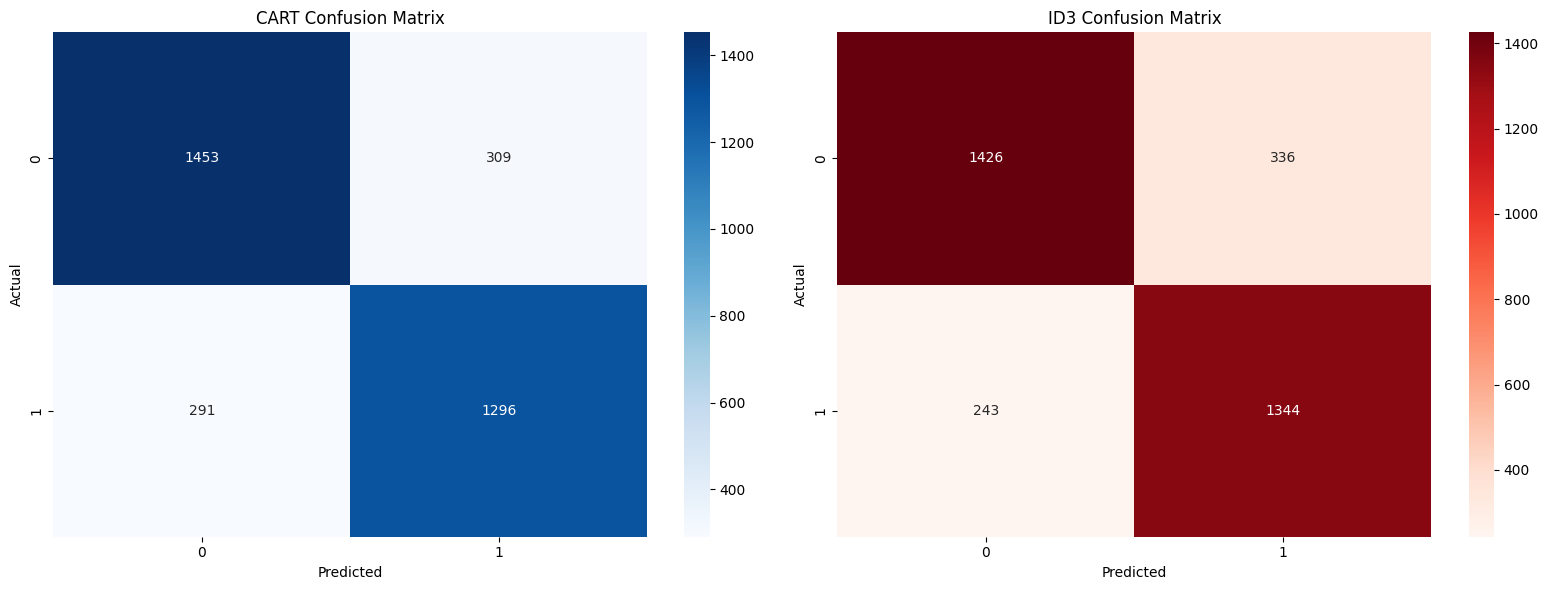

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

cm_cart = confusion_matrix(y_test, y_pred_cart)
sns.heatmap(cm_cart, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('CART Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

cm_id3 = confusion_matrix(y_test, y_pred_id3)
sns.heatmap(cm_id3, annot=True, fmt='d', cmap='Reds', ax=axes[1])
axes[1].set_title('ID3 Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

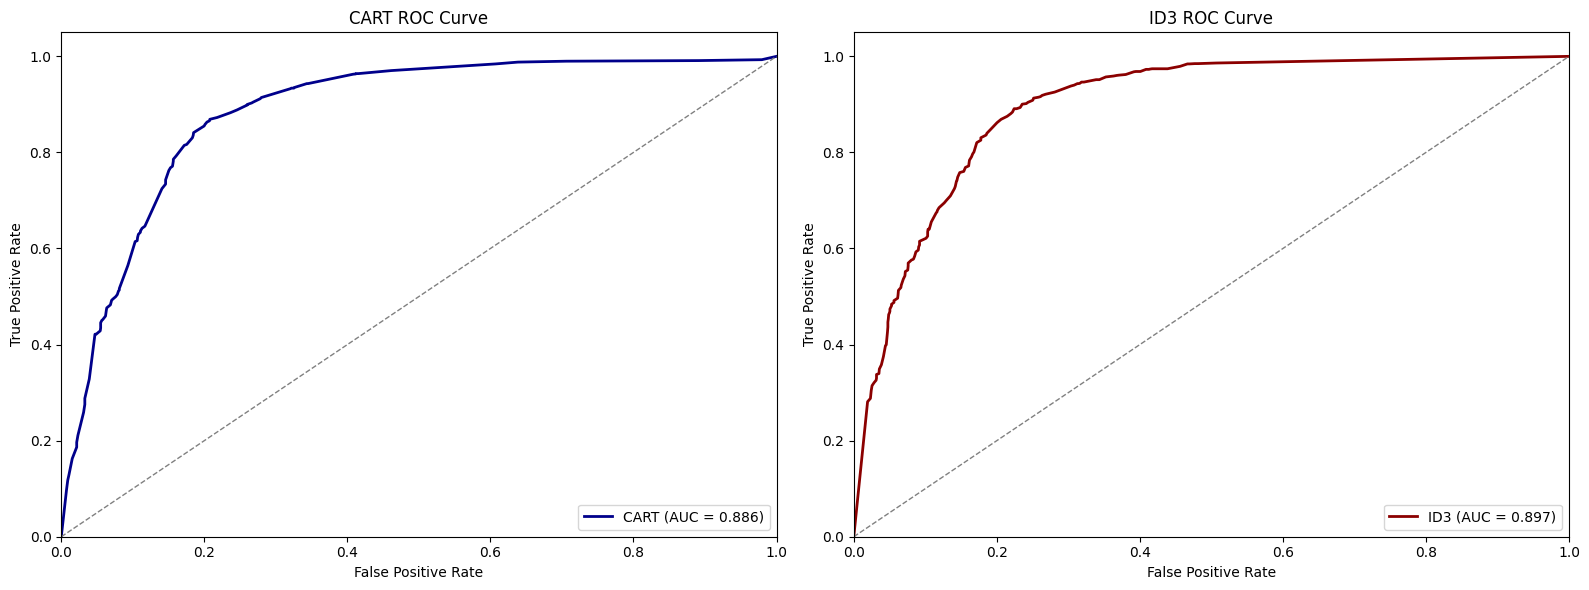

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

fpr_cart, tpr_cart, _ = roc_curve(y_test, y_proba_cart)
roc_auc_cart = roc_auc_score(y_test, y_proba_cart)

axes[0].plot(fpr_cart, tpr_cart, color='darkblue', lw=2,
            label=f'CART (AUC = {roc_auc_cart:.3f})')
axes[0].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('CART ROC Curve')
axes[0].legend(loc="lower right")

fpr_id3, tpr_id3, _ = roc_curve(y_test, y_proba_id3)
roc_auc_id3 = roc_auc_score(y_test, y_proba_id3)

axes[1].plot(fpr_id3, tpr_id3, color='darkred', lw=2,
            label=f'ID3 (AUC = {roc_auc_id3:.3f})')
axes[1].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ID3 ROC Curve')
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

In [18]:
accuracy_cart = accuracy_score(y_test, y_pred_cart)
precision_cart = precision_score(y_test, y_pred_cart)
recall_cart = recall_score(y_test, y_pred_cart)
f1_cart = f1_score(y_test, y_pred_cart)

accuracy_id3 = accuracy_score(y_test, y_pred_id3)
precision_id3 = precision_score(y_test, y_pred_id3)
recall_id3 = recall_score(y_test, y_pred_id3)
f1_id3 = f1_score(y_test, y_pred_id3)

print("CART Metrics:")
print(f"Accuracy: {accuracy_cart:.4f}")
print(f"Precision: {precision_cart:.4f}")
print(f"Recall: {recall_cart:.4f}")
print(f"F1-Score: {f1_cart:.4f}")
print(f"AUC: {roc_auc_cart:.4f}")

print("\nID3 Metrics:")
print(f"Accuracy: {accuracy_id3:.4f}")
print(f"Precision: {precision_id3:.4f}")
print(f"Recall: {recall_id3:.4f}")
print(f"F1-Score: {f1_id3:.4f}")
print(f"AUC: {roc_auc_id3:.4f}")

CART Metrics:
Accuracy: 0.8208
Precision: 0.8075
Recall: 0.8166
F1-Score: 0.8120
AUC: 0.8856

ID3 Metrics:
Accuracy: 0.8271
Precision: 0.8000
Recall: 0.8469
F1-Score: 0.8228
AUC: 0.8967


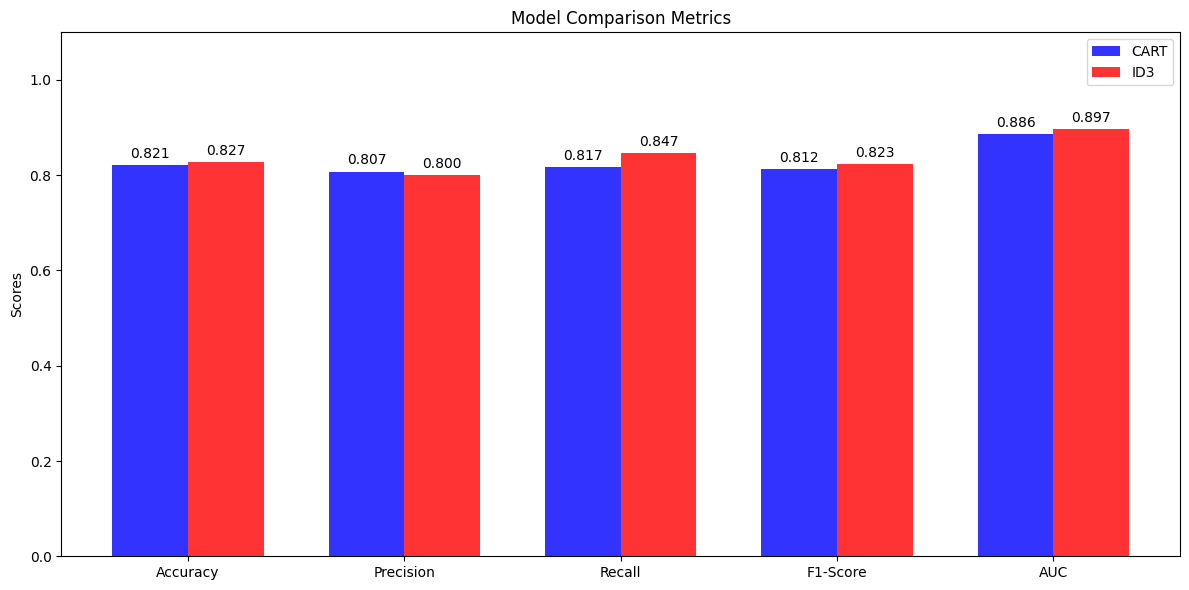

In [19]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
cart_scores = [accuracy_cart, precision_cart, recall_cart, f1_cart, roc_auc_cart]
id3_scores = [accuracy_id3, precision_id3, recall_id3, f1_id3, roc_auc_id3]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, cart_scores, width, label='CART', color='blue', alpha=0.8)
rects2 = ax.bar(x + width/2, id3_scores, width, label='ID3', color='red', alpha=0.8)

ax.set_ylabel('Scores')
ax.set_title('Model Comparison Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.ylim([0, 1.1])
plt.tight_layout()
plt.show()

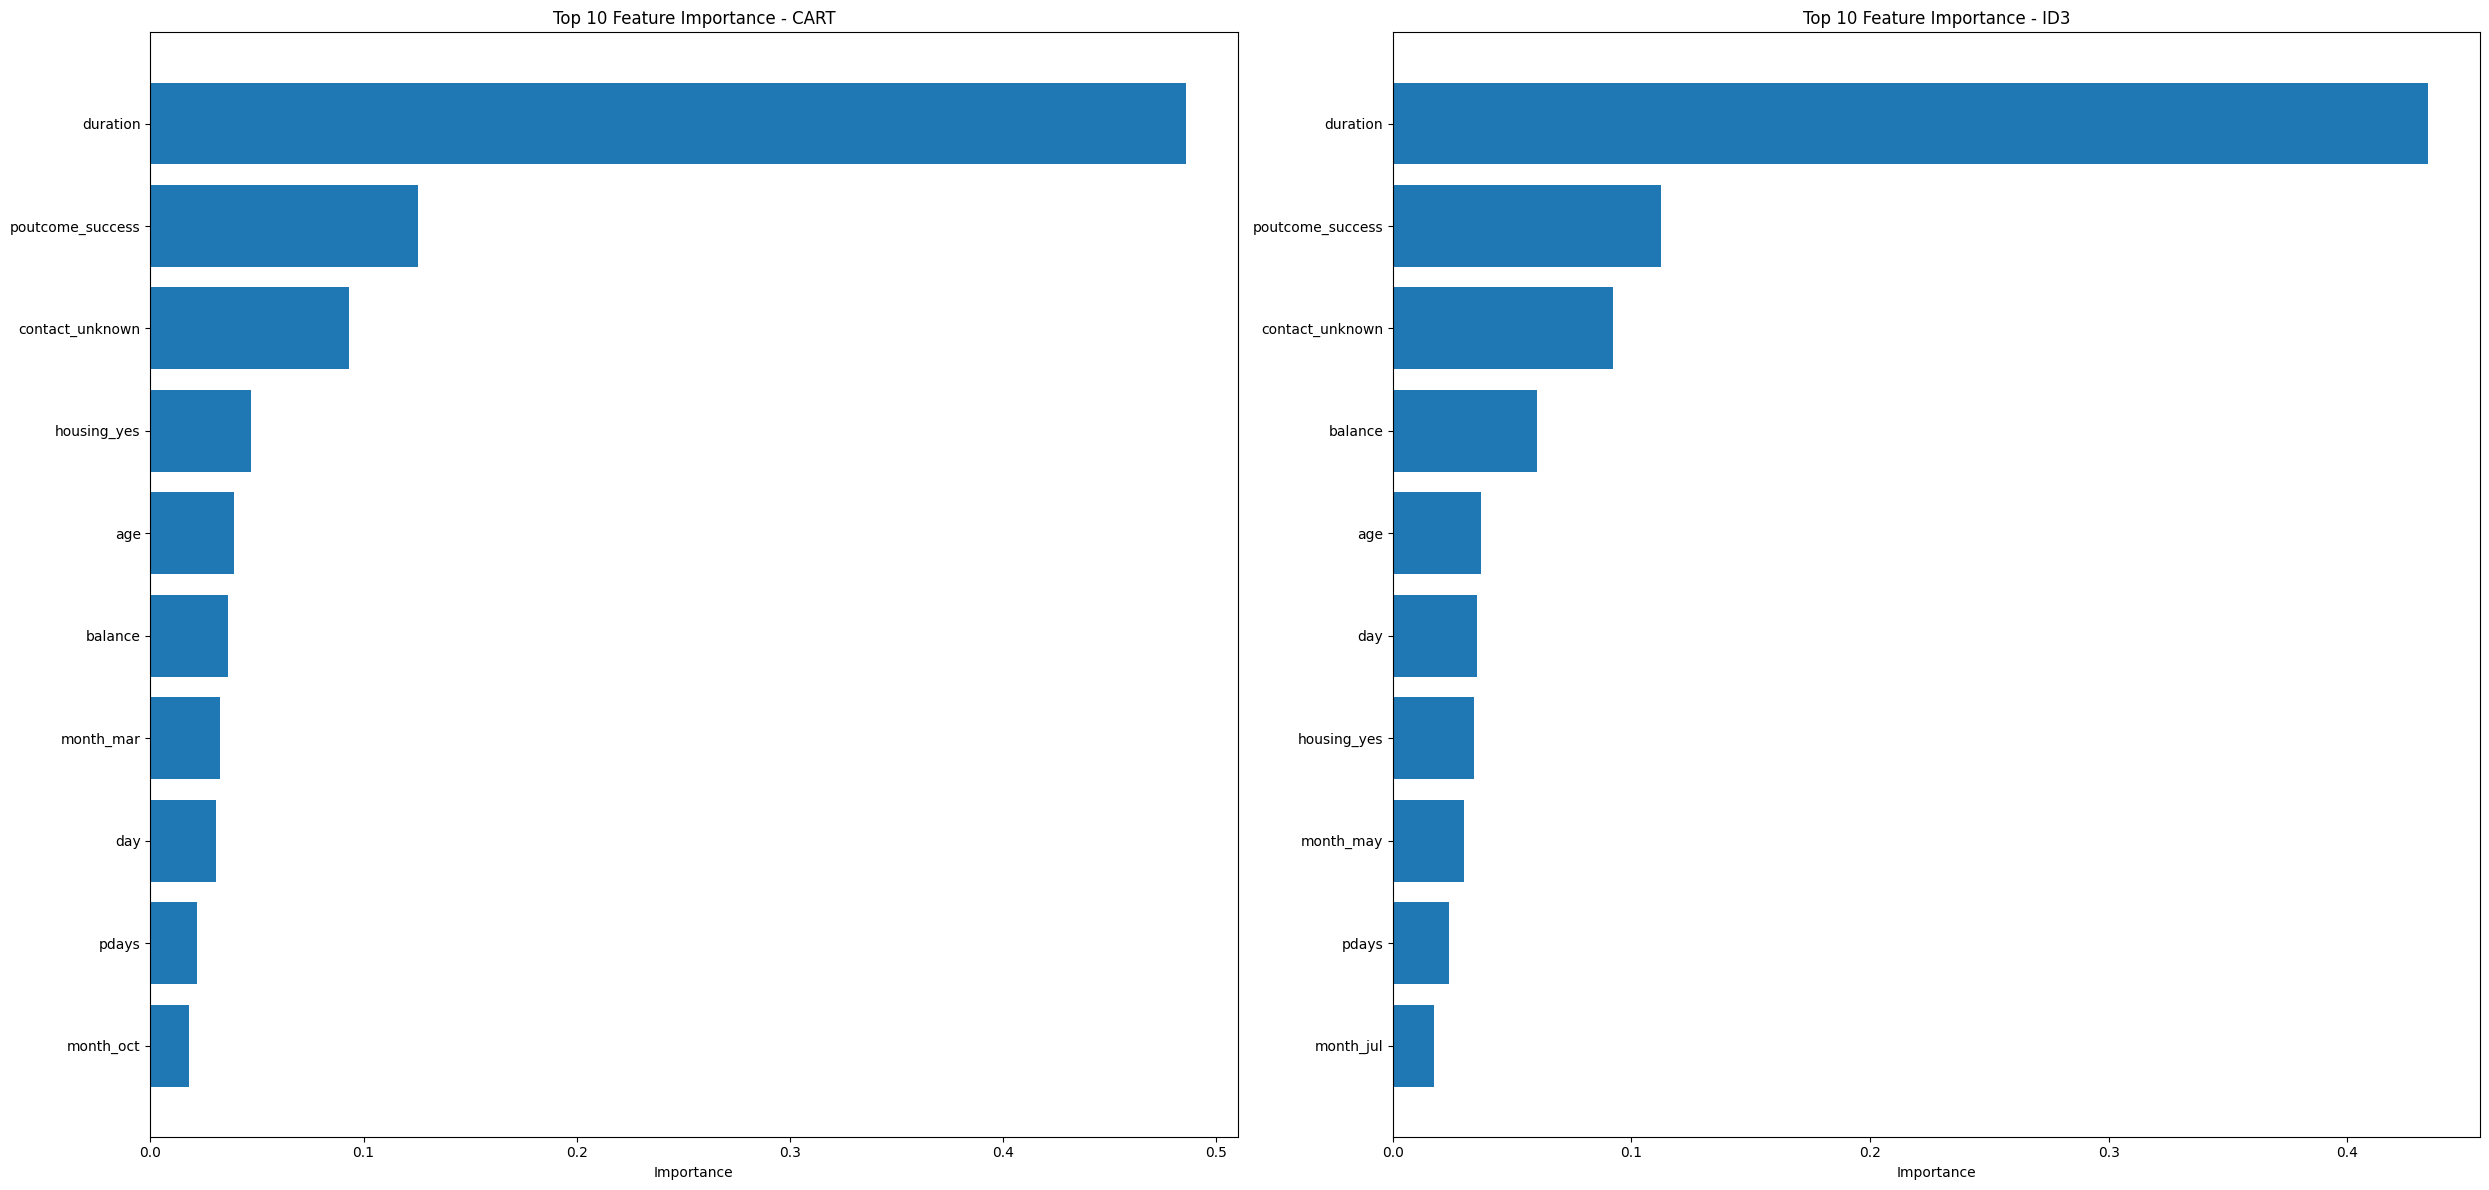

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(25, 12))

top_features_cart = X.columns[np.argsort(cart_best.feature_importances_)[-10:]][::-1]
top_importances_cart = cart_best.feature_importances_[np.argsort(cart_best.feature_importances_)[-10:]][::-1]

axes[0].barh(range(len(top_features_cart)), top_importances_cart)
axes[0].set_yticks(range(len(top_features_cart)))
axes[0].set_yticklabels(top_features_cart)
axes[0].invert_yaxis()
axes[0].set_xlabel('Importance')
axes[0].set_title('Top 10 Feature Importance - CART')

top_features_id3 = X.columns[np.argsort(id3_best.feature_importances_)[-10:]][::-1]
top_importances_id3 = id3_best.feature_importances_[np.argsort(id3_best.feature_importances_)[-10:]][::-1]

axes[1].barh(range(len(top_features_id3)), top_importances_id3)
axes[1].set_yticks(range(len(top_features_id3)))
axes[1].set_yticklabels(top_features_id3)
axes[1].invert_yaxis()
axes[1].set_xlabel('Importance')
axes[1].set_title('Top 10 Feature Importance - ID3')

plt.tight_layout()
plt.show()

In [21]:
print("="*60)
print("CART CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test, y_pred_cart,
                          target_names=['No Subscription', 'Subscription']))

print("\n" + "="*60)
print("ID3 CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test, y_pred_id3,
                          target_names=['No Subscription', 'Subscription']))

CART CLASSIFICATION REPORT
                 precision    recall  f1-score   support

No Subscription       0.83      0.82      0.83      1762
   Subscription       0.81      0.82      0.81      1587

       accuracy                           0.82      3349
      macro avg       0.82      0.82      0.82      3349
   weighted avg       0.82      0.82      0.82      3349


ID3 CLASSIFICATION REPORT
                 precision    recall  f1-score   support

No Subscription       0.85      0.81      0.83      1762
   Subscription       0.80      0.85      0.82      1587

       accuracy                           0.83      3349
      macro avg       0.83      0.83      0.83      3349
   weighted avg       0.83      0.83      0.83      3349



In [22]:
comparison_df = pd.DataFrame({
    'Metric': metrics,
    'CART': cart_scores,
    'ID3': id3_scores,
    'Difference': np.array(cart_scores) - np.array(id3_scores)
})

print("\n" + "="*60)
print("FINAL MODEL COMPARISON")
print("="*60)
print(comparison_df)

print("\n" + "="*60)
print("BEST MODEL SELECTION")
print("="*60)
for metric in metrics:
    idx = metrics.index(metric)
    if cart_scores[idx] > id3_scores[idx]:
        print(f"{metric}: CART wins by {cart_scores[idx] - id3_scores[idx]:.4f}")
    elif id3_scores[idx] > cart_scores[idx]:
        print(f"{metric}: ID3 wins by {id3_scores[idx] - cart_scores[idx]:.4f}")
    else:
        print(f"{metric}: Tie")


FINAL MODEL COMPARISON
      Metric      CART       ID3  Difference
0   Accuracy  0.820842  0.827113   -0.006271
1  Precision  0.807477  0.800000    0.007477
2     Recall  0.816635  0.846881   -0.030246
3   F1-Score  0.812030  0.822773   -0.010743
4        AUC  0.885645  0.896747   -0.011102

BEST MODEL SELECTION
Accuracy: ID3 wins by 0.0063
Precision: CART wins by 0.0075
Recall: ID3 wins by 0.0302
F1-Score: ID3 wins by 0.0107
AUC: ID3 wins by 0.0111


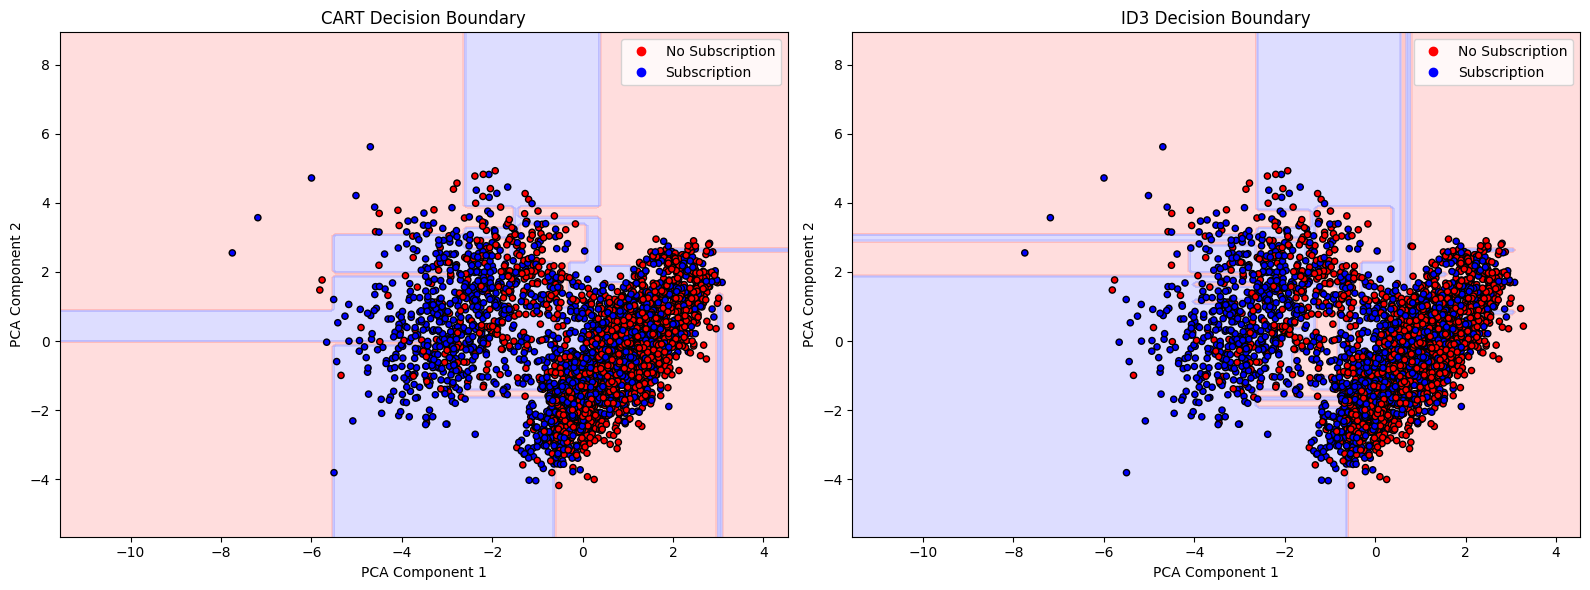

In [25]:
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

cart_pca_model = DecisionTreeClassifier(**cart_cv.best_params_)
cart_pca_model.fit(X_train_pca, y_train)

id3_pca_model = DecisionTreeClassifier(**id3_cv.best_params_)
id3_pca_model.fit(X_train_pca, y_train)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

cmap_background = ListedColormap(['#FFAAAA', '#AAAAFF'])
cmap_points = ListedColormap(['#FF0000', '#0000FF'])

x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z_cart = cart_pca_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z_cart = Z_cart.reshape(xx.shape)

axes[0].contourf(xx, yy, Z_cart, alpha=0.4, cmap=cmap_background)
scatter1 = axes[0].scatter(X_test_pca[:, 0], X_test_pca[:, 1],
                          c=y_test, s=20, edgecolor='k', cmap=cmap_points)
axes[0].set_xlabel('PCA Component 1')
axes[0].set_ylabel('PCA Component 2')
axes[0].set_title('CART Decision Boundary')
axes[0].legend(handles=scatter1.legend_elements()[0],
              labels=['No Subscription', 'Subscription'])

Z_id3 = id3_pca_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z_id3 = Z_id3.reshape(xx.shape)

axes[1].contourf(xx, yy, Z_id3, alpha=0.4, cmap=cmap_background)
scatter2 = axes[1].scatter(X_test_pca[:, 0], X_test_pca[:, 1],
                          c=y_test, s=20, edgecolor='k', cmap=cmap_points)
axes[1].set_xlabel('PCA Component 1')
axes[1].set_ylabel('PCA Component 2')
axes[1].set_title('ID3 Decision Boundary')
axes[1].legend(handles=scatter2.legend_elements()[0],
              labels=['No Subscription', 'Subscription'])

plt.tight_layout()
plt.show()

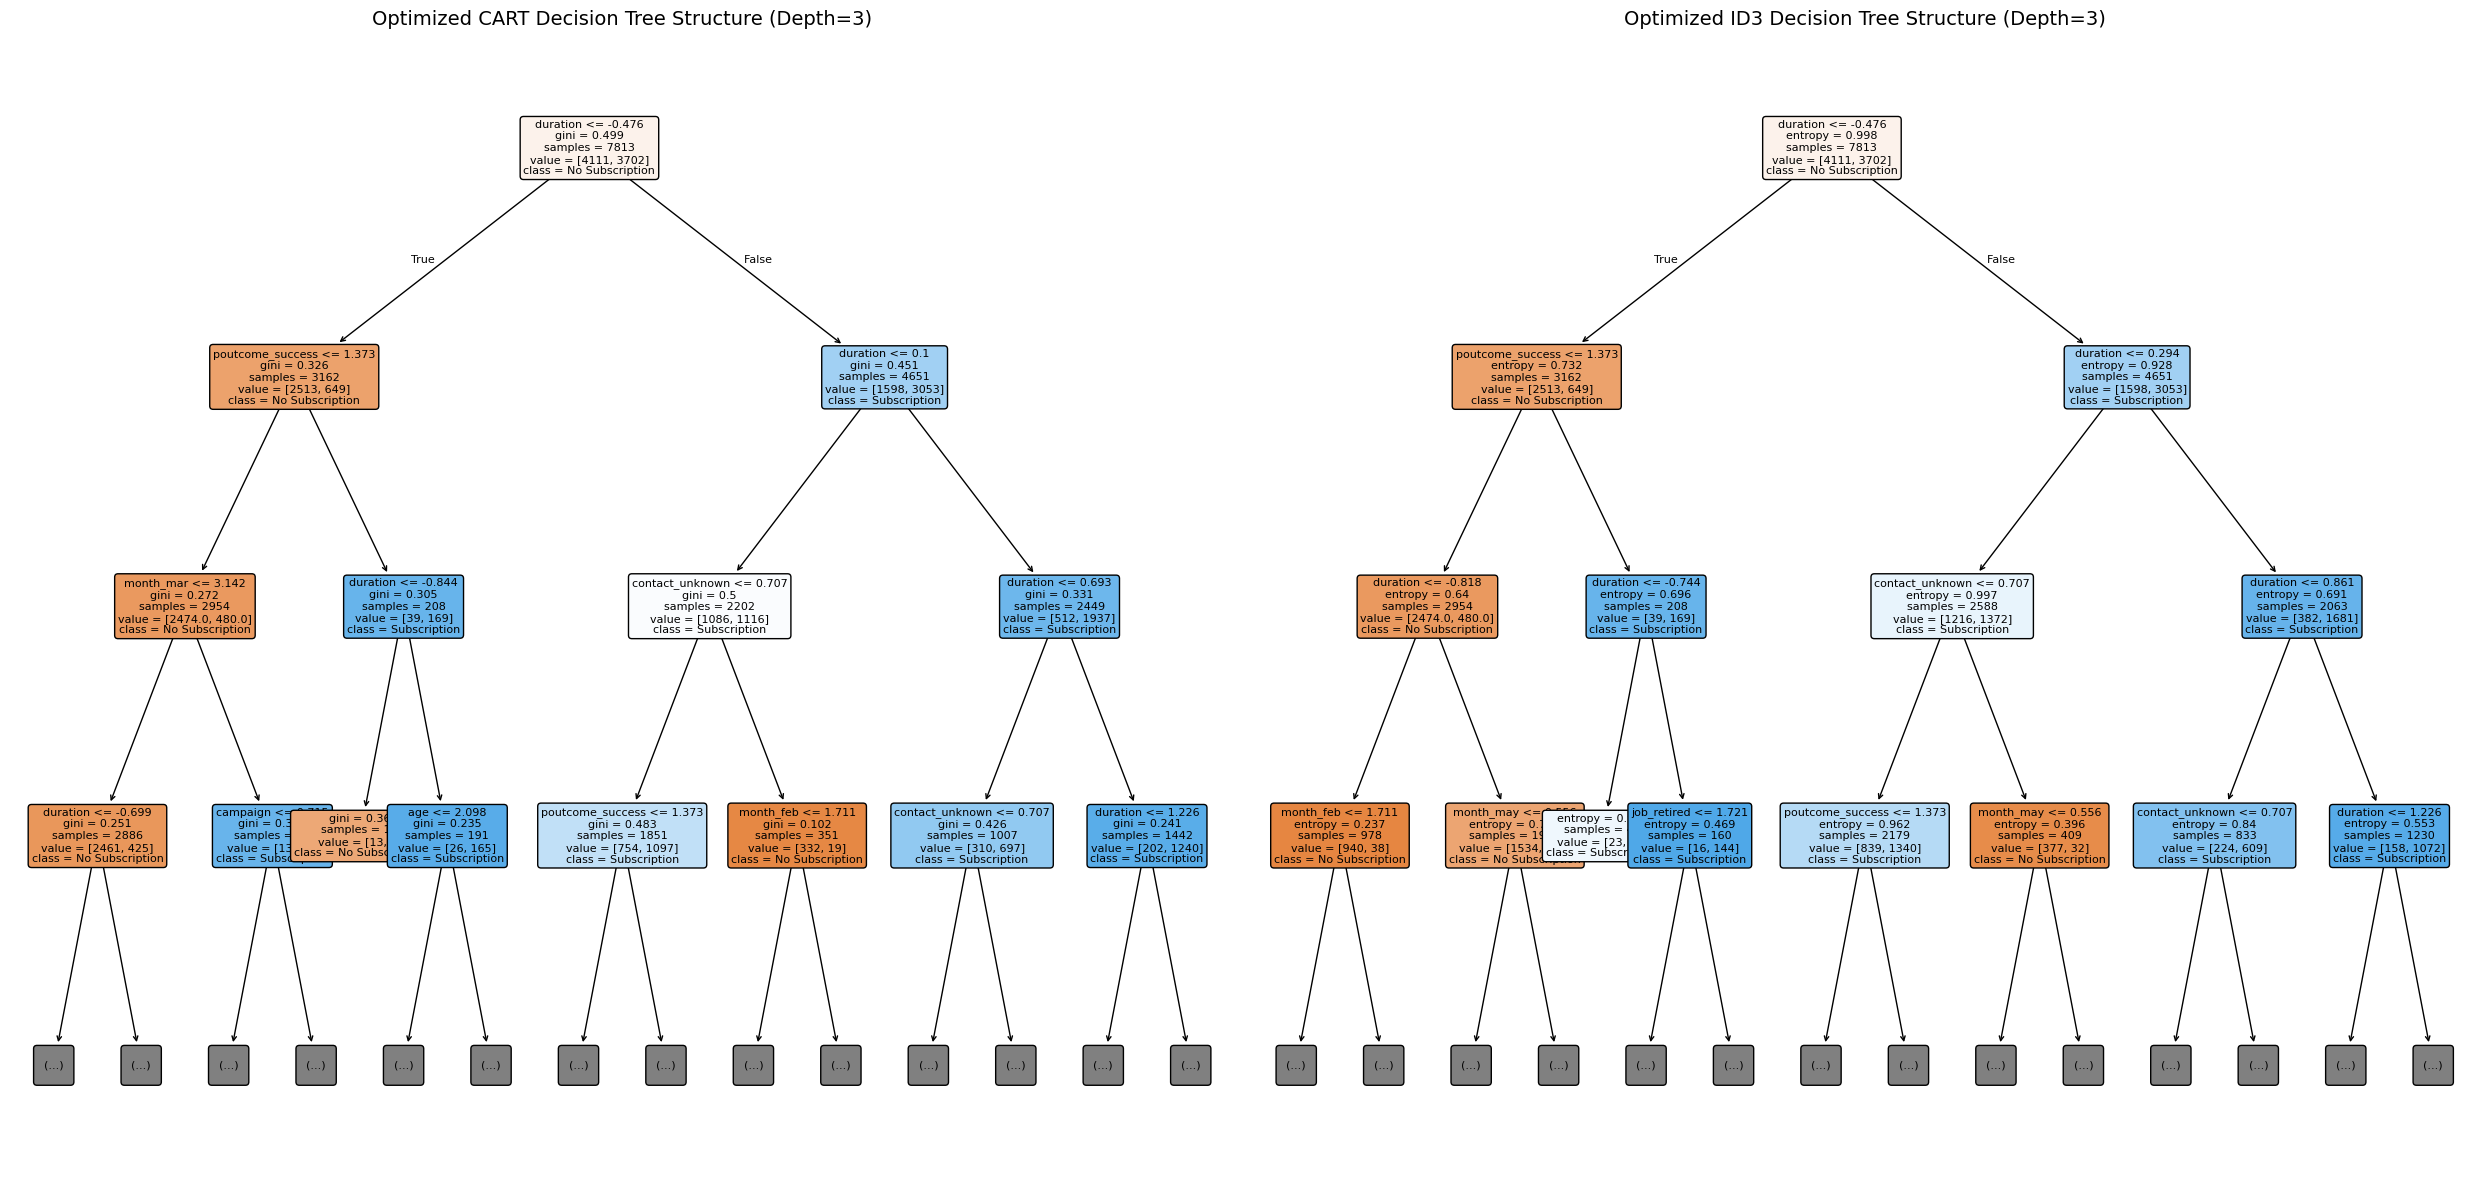

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(25, 12))

plot_tree(cart_best,
          feature_names=X.columns.tolist(),
          class_names=['No Subscription', 'Subscription'],
          filled=True,
          rounded=True,
          fontsize=8,
          max_depth=3,
          ax=axes[0])
axes[0].set_title('Optimized CART Decision Tree Structure (Depth=3)', fontsize=14)

plot_tree(id3_best,
          feature_names=X.columns.tolist(),
          class_names=['No Subscription', 'Subscription'],
          filled=True,
          rounded=True,
          fontsize=8,
          max_depth=3,
          ax=axes[1])
axes[1].set_title('Optimized ID3 Decision Tree Structure (Depth=3)', fontsize=14)

plt.tight_layout()
plt.show()